# Approximate Bayesian Computation

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

#from scripts.rf_selector import select_model

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(1346)

## Finding parameters the ABC way with tolerance ε = 1 

### Model to be used for fitting

In [4]:
def model(*ps):
    alpha = ps[0]
    k = ps[1]
    vth = ps[2]

    class microfilariae(object):
        def __init__(self):
            self.pop_size = 1000
            self.fecundity = 9
            self.ttreat = np.ones(1000)
            self.WF = np.random.randint(0,100, 1000)
            self.WM = np.random.randint(0,100, 1000)
            self.gamma = 0.1
            self.Mf = np.random.poisson(2.5, 1000)
            self.bite_risk = np.random.gamma(k, scale=1/k, size=1000)
            self.bednet = np.random.binomial(1000, 0.47)
            self.age = [np.random.uniform(0, 100*12) for _ in range(1000)]
            
        def mf_dynamics(self):
            self.worm_dynamics()
            verbose = False
            if verbose:
                print("Updating MF dynamics with alpha =", alpha, "k =", k, "and vth = ", vth)

            for i in range(self.pop_size):
                self.Mf[i] *= 1 - self.gamma
                if self.WM[i] == 0:
                    continue
                if self.ttreat[i] <= self.fecundity:
                    continue
                self.Mf[i] += alpha * self.WF[i]
                if self.Mf[i] < 0:
                    self.Mf[i] = 0
            return self.Mf
        
        def worm_dynamics(self):
            verbose = False
            if verbose:
                print("Updating worm dynamics")
            for i in range(1000):
                age_prop = self.age[i] / (9.0 * 12.0)
                bite_rate = min(age_prop, 1.0)
                BNR = 0.03 
                birth_rate = 0.5 * 10 * self.bite_risk[i] * vth * 0.414 * 0.32 * 0.00275 * 5 * 5 * BNR
                
                male_death_rate = self.WM[i] * 0.0104
                female_death_rate = self.WF[i] * 0.0104

                male_births = np.random.poisson(birth_rate) if birth_rate > 0 else 0
                female_births = np.random.poisson(birth_rate) if birth_rate > 0 else 0
                male_deaths = np.random.poisson(male_death_rate) if male_death_rate > 0 else 0
                female_deaths = np.random.poisson(female_death_rate) if female_death_rate > 0 else 0

                self.WM[i] += male_births - male_deaths
                self.WF[i] += female_births - female_deaths
                if self.WM[i] < 0:
                    self.WM[i] = 0
                if self.WF[i] < 0:
                    self.WF[i] = 0

    
    return(microfilariae().mf_dynamics())

## Generating the observed data with alpha = 0.4, k = 0.55 and vth = 120

CPU times: total: 0 ns
Wall time: 13.1 ms


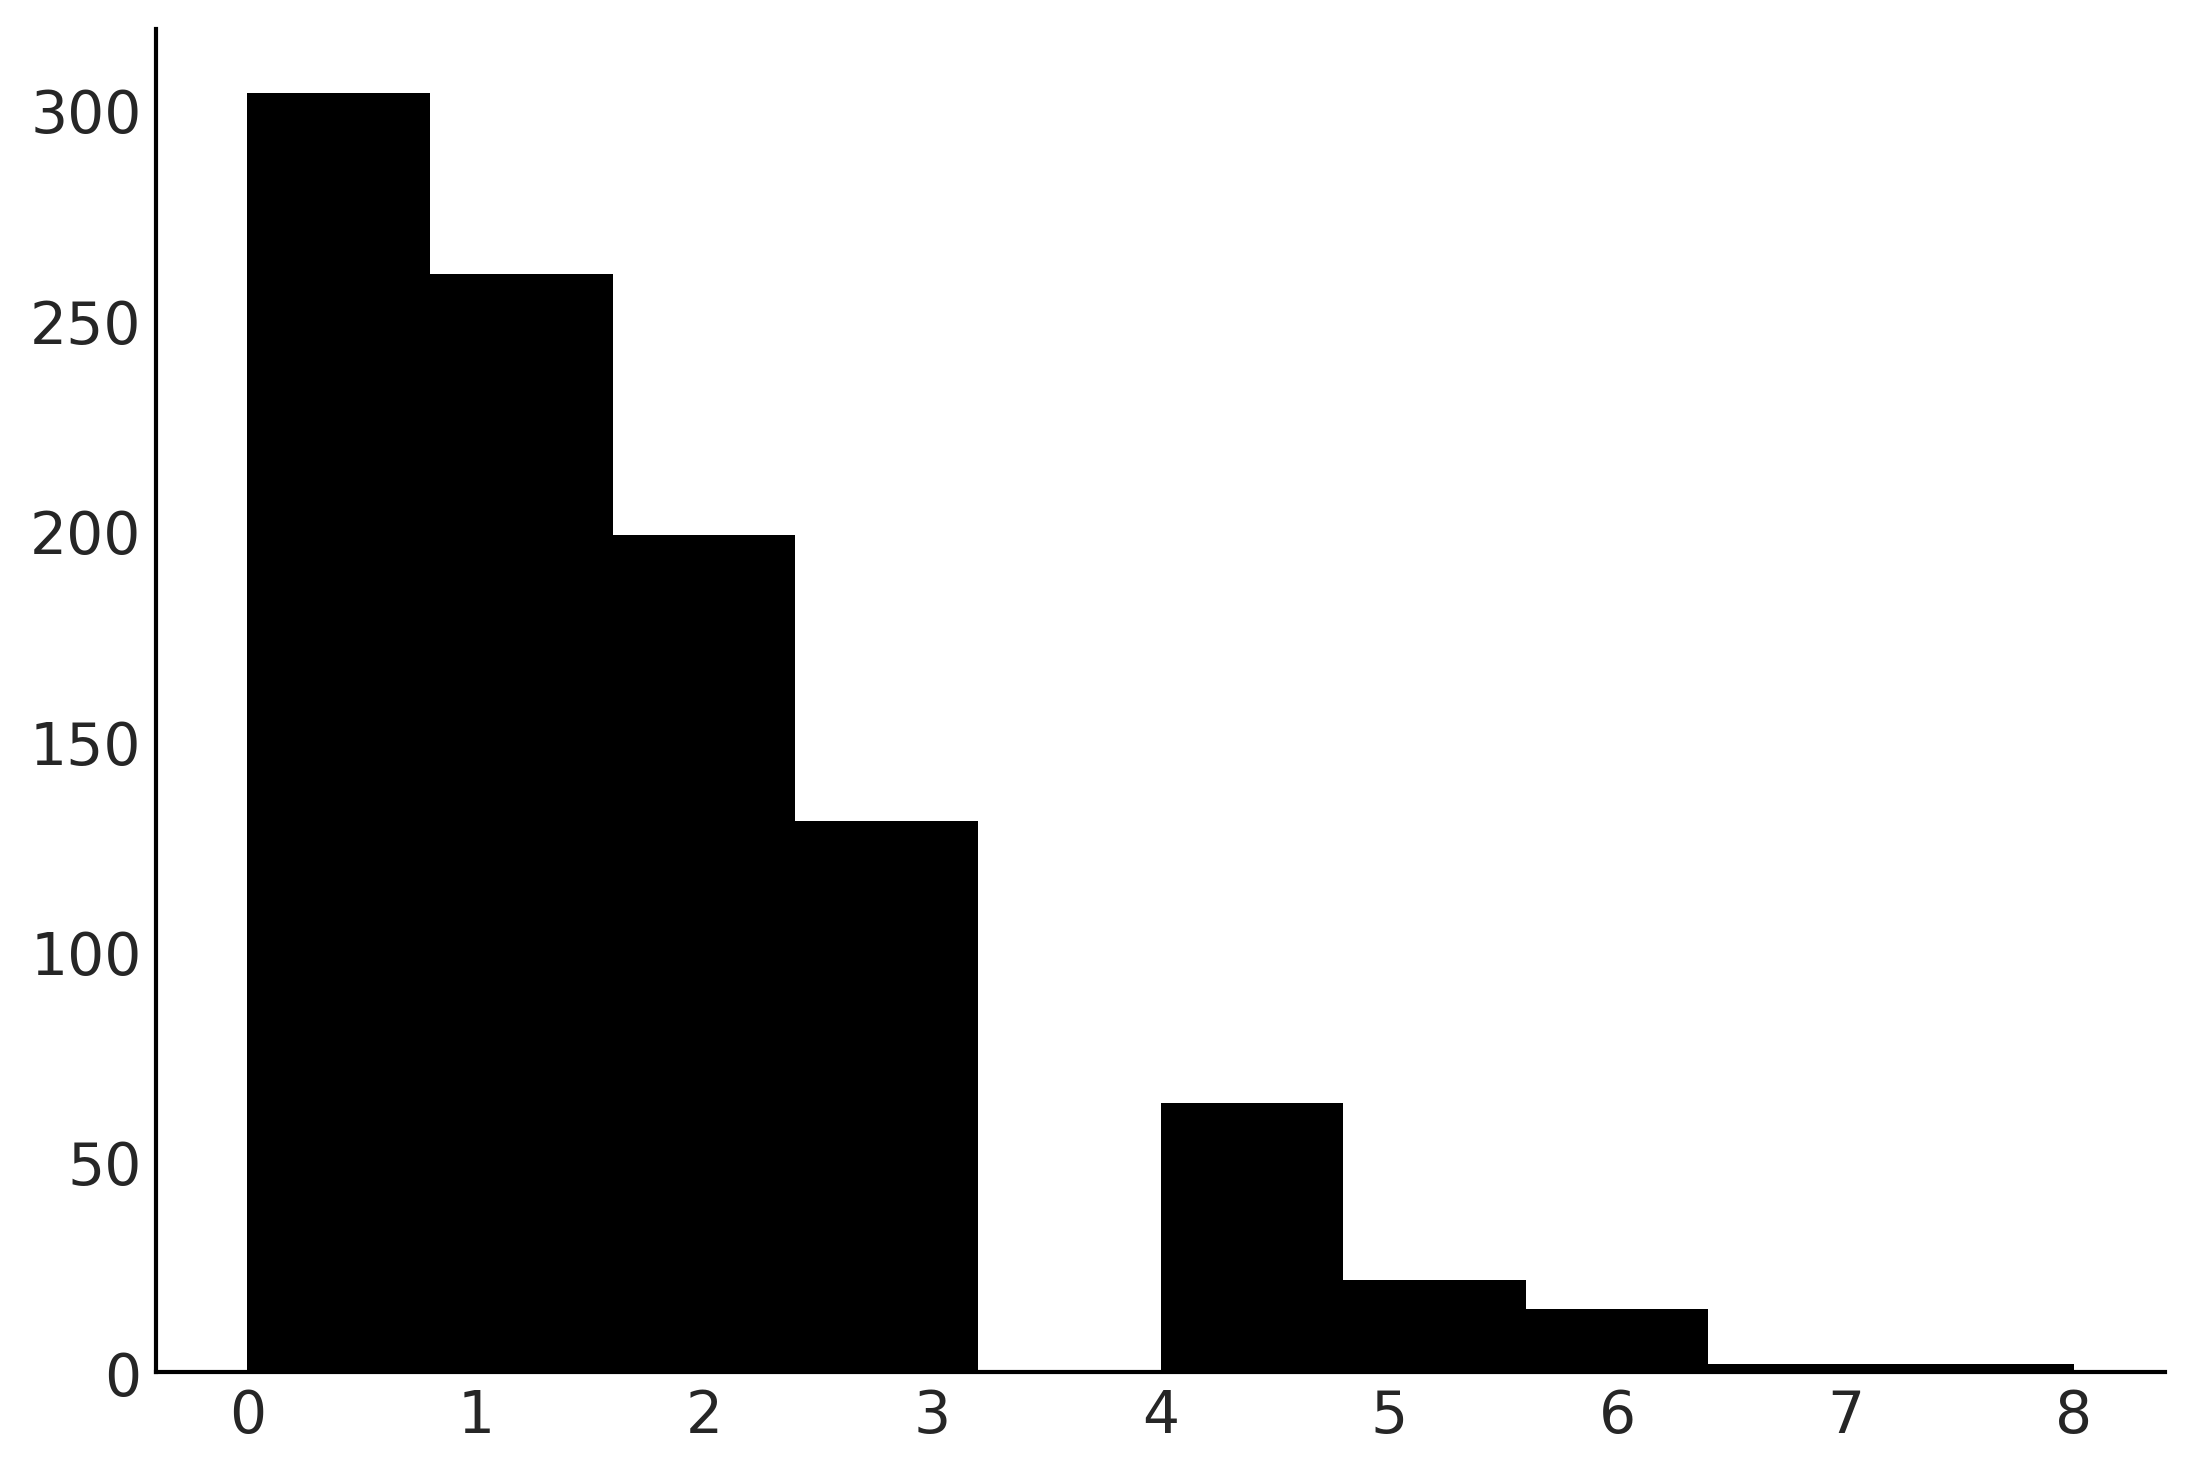

In [5]:
%time xs = model(0.4, 0.055, 120)
plt.hist(xs);

## The computation: setting up the model fitting

The `prior` distribution for each parameter has been defined with the tolerance `epsilon = 1` with 4 chains i.e. 4 runs of MCMC

In [6]:
with pm.Model() as lf:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 1,
                     observed = xs)
    
    trace_g = pm.sample_prior_predictive()
    
    trace_g.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp = pm.sample_posterior_predictive(trace_g)

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [s]


Output()

## Point estimates of fit with their HDI intervals

In [7]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vth,122.169,21.130,75.792,155.030,2.363,1.677,87.0,164.0,1.06
alpha,0.175,0.204,0.006,0.729,0.043,0.031,13.0,6.0,1.23
k,0.105,0.100,0.007,0.308,0.014,0.010,95.0,68.0,1.12


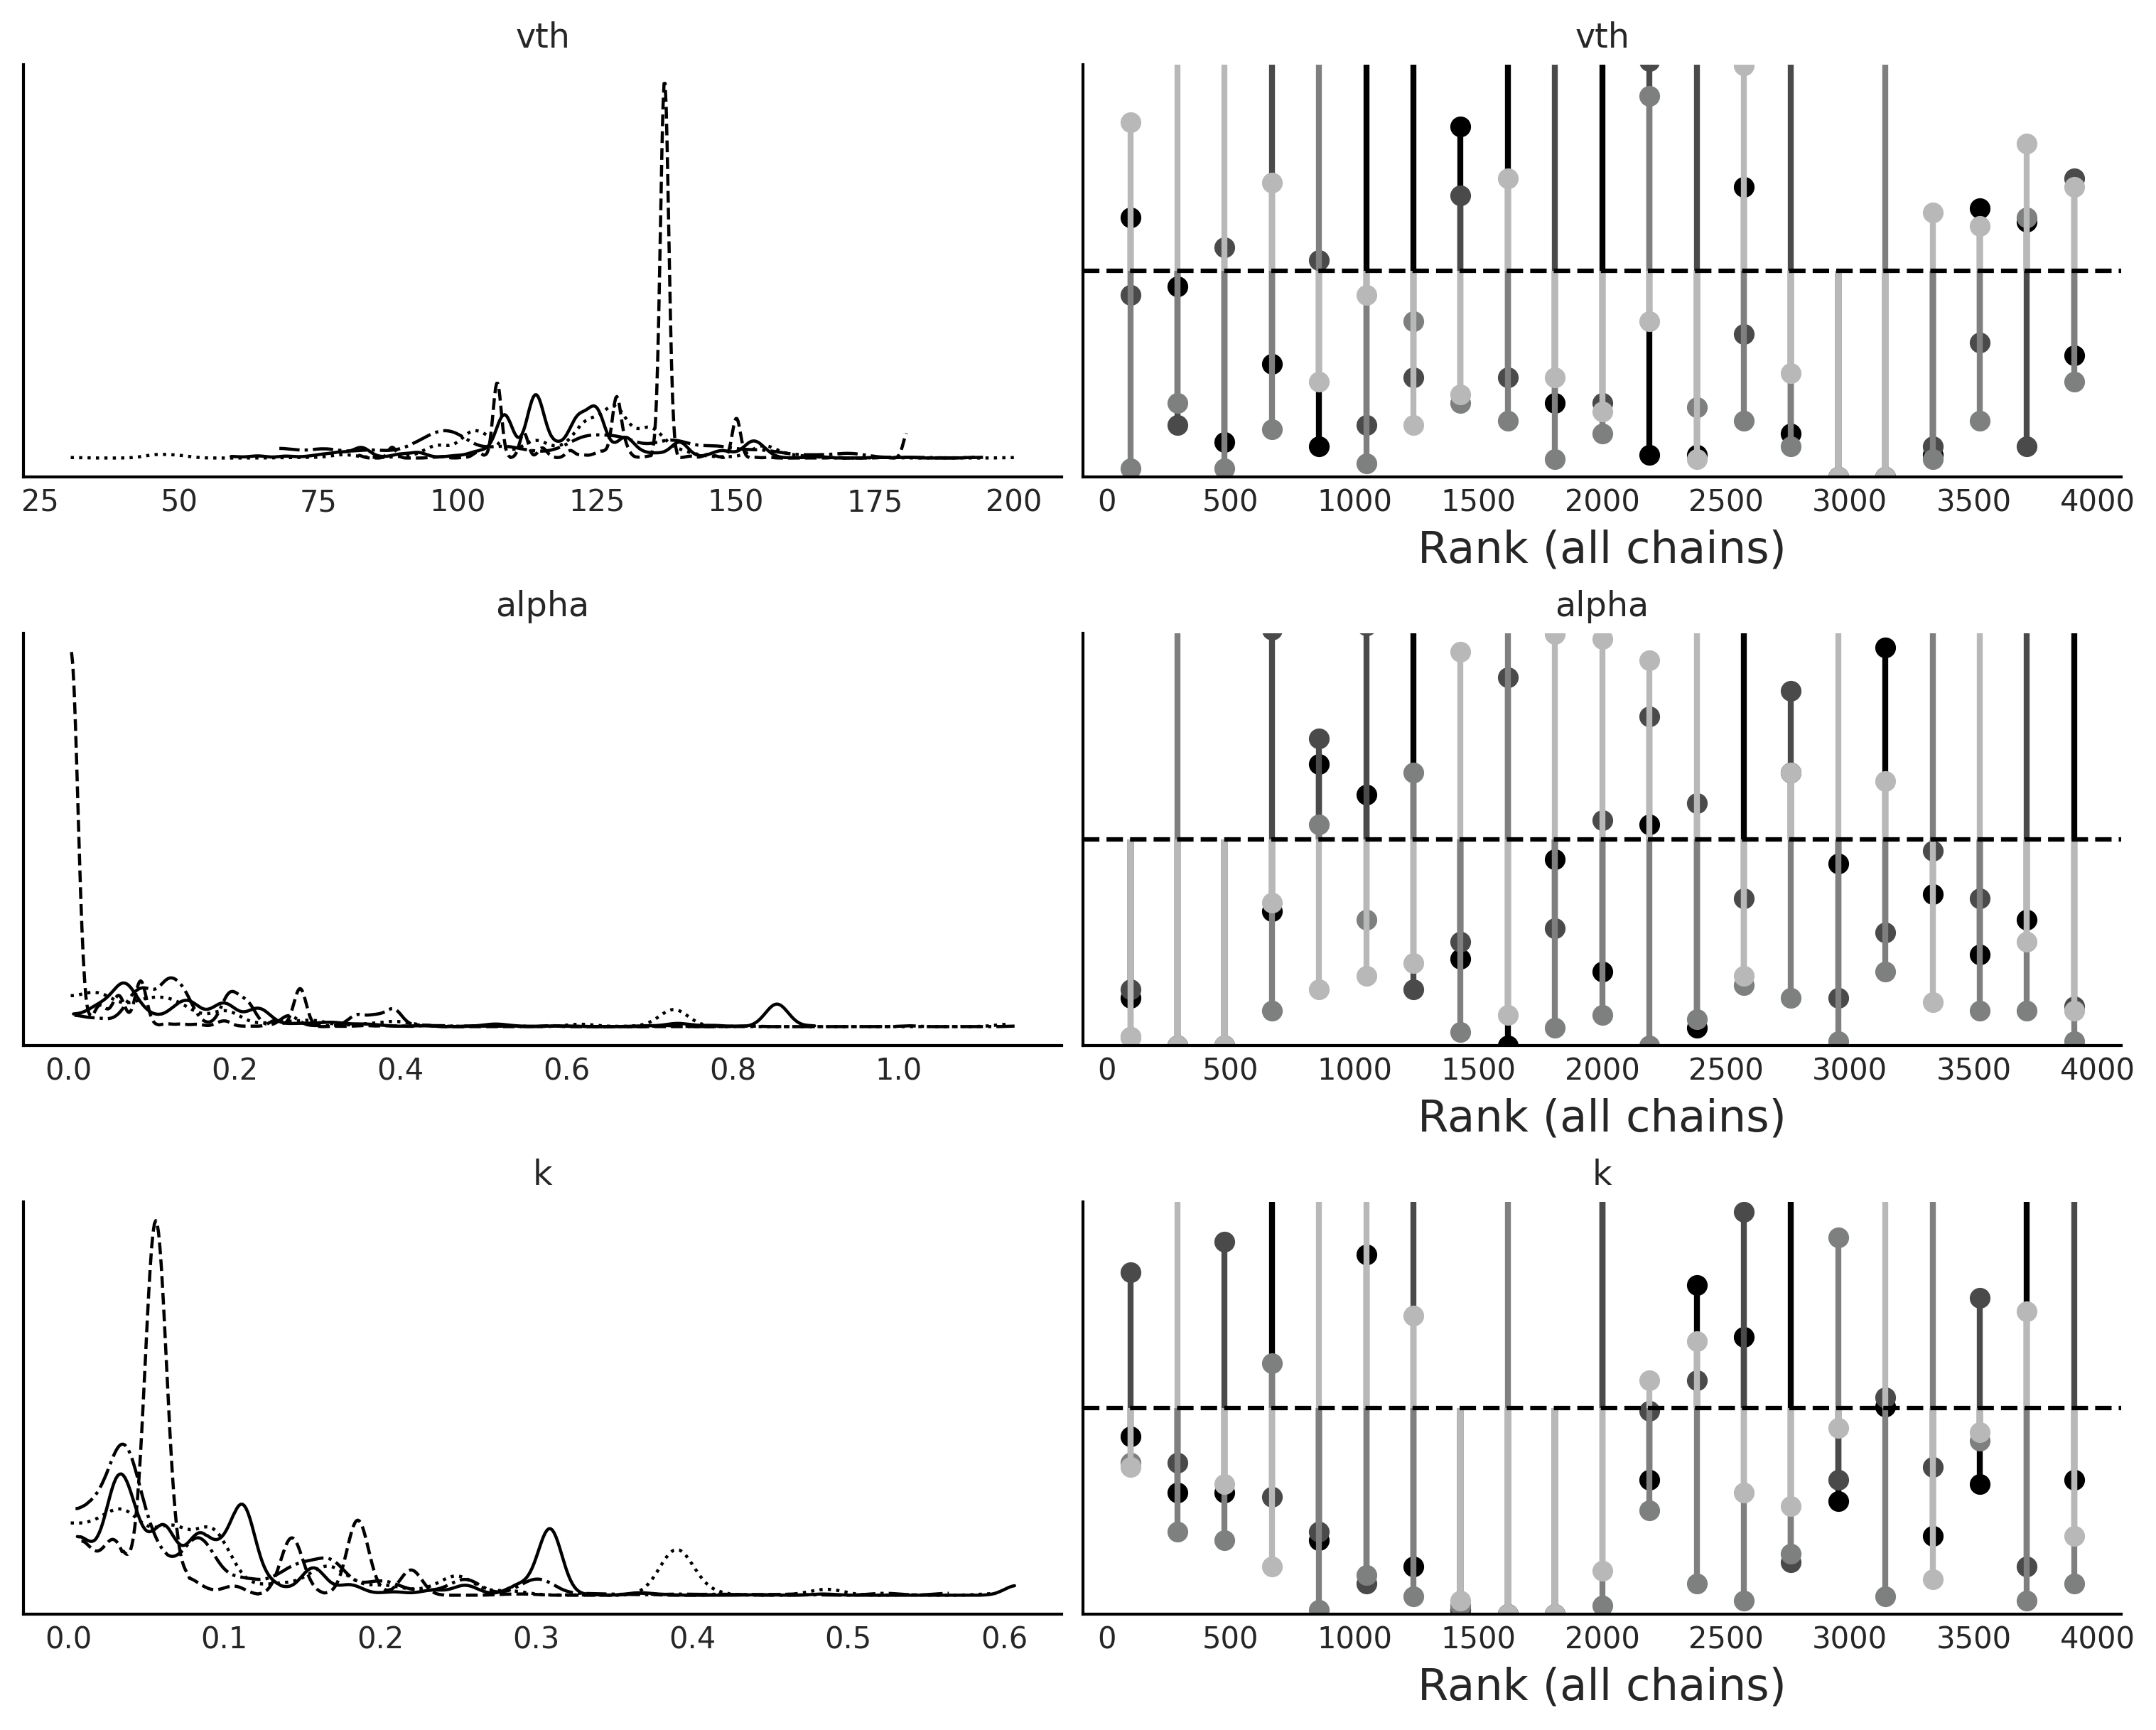

In [8]:
az.plot_trace(trace_g, kind = "rank_vlines", figsize = (10, 8));

## Comparing the HDI intervals for the 4 chains

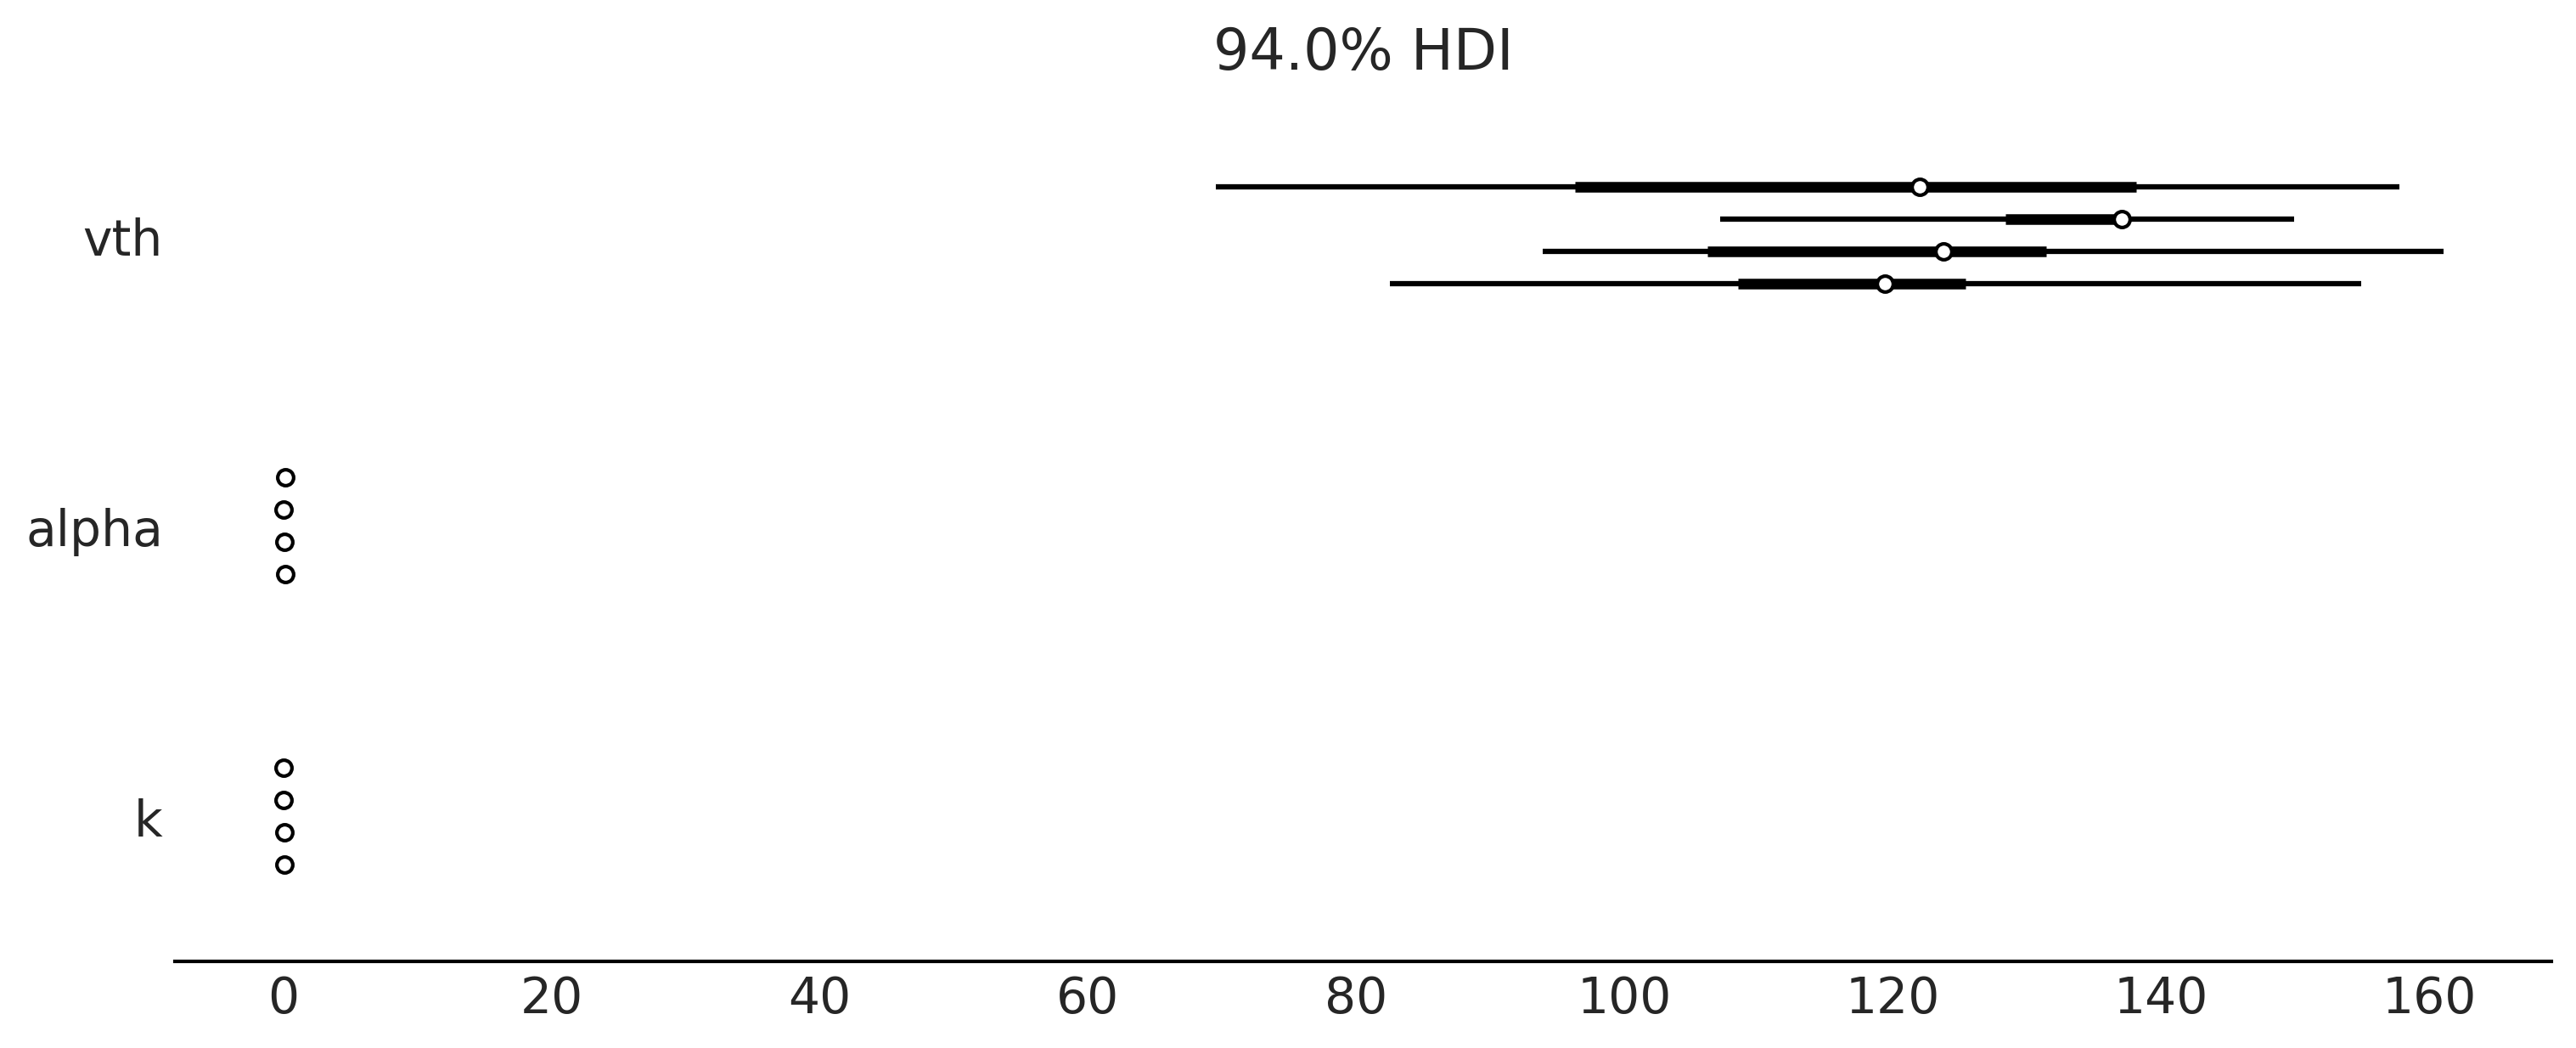

In [9]:
az.plot_forest(trace_g, figsize = (10, 4));

## a KDE plot of the parametters and their pairs

array([[<Axes: ylabel='vth'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='vth', ylabel='k'>, <Axes: xlabel='alpha'>,
        <Axes: xlabel='k'>]], dtype=object)

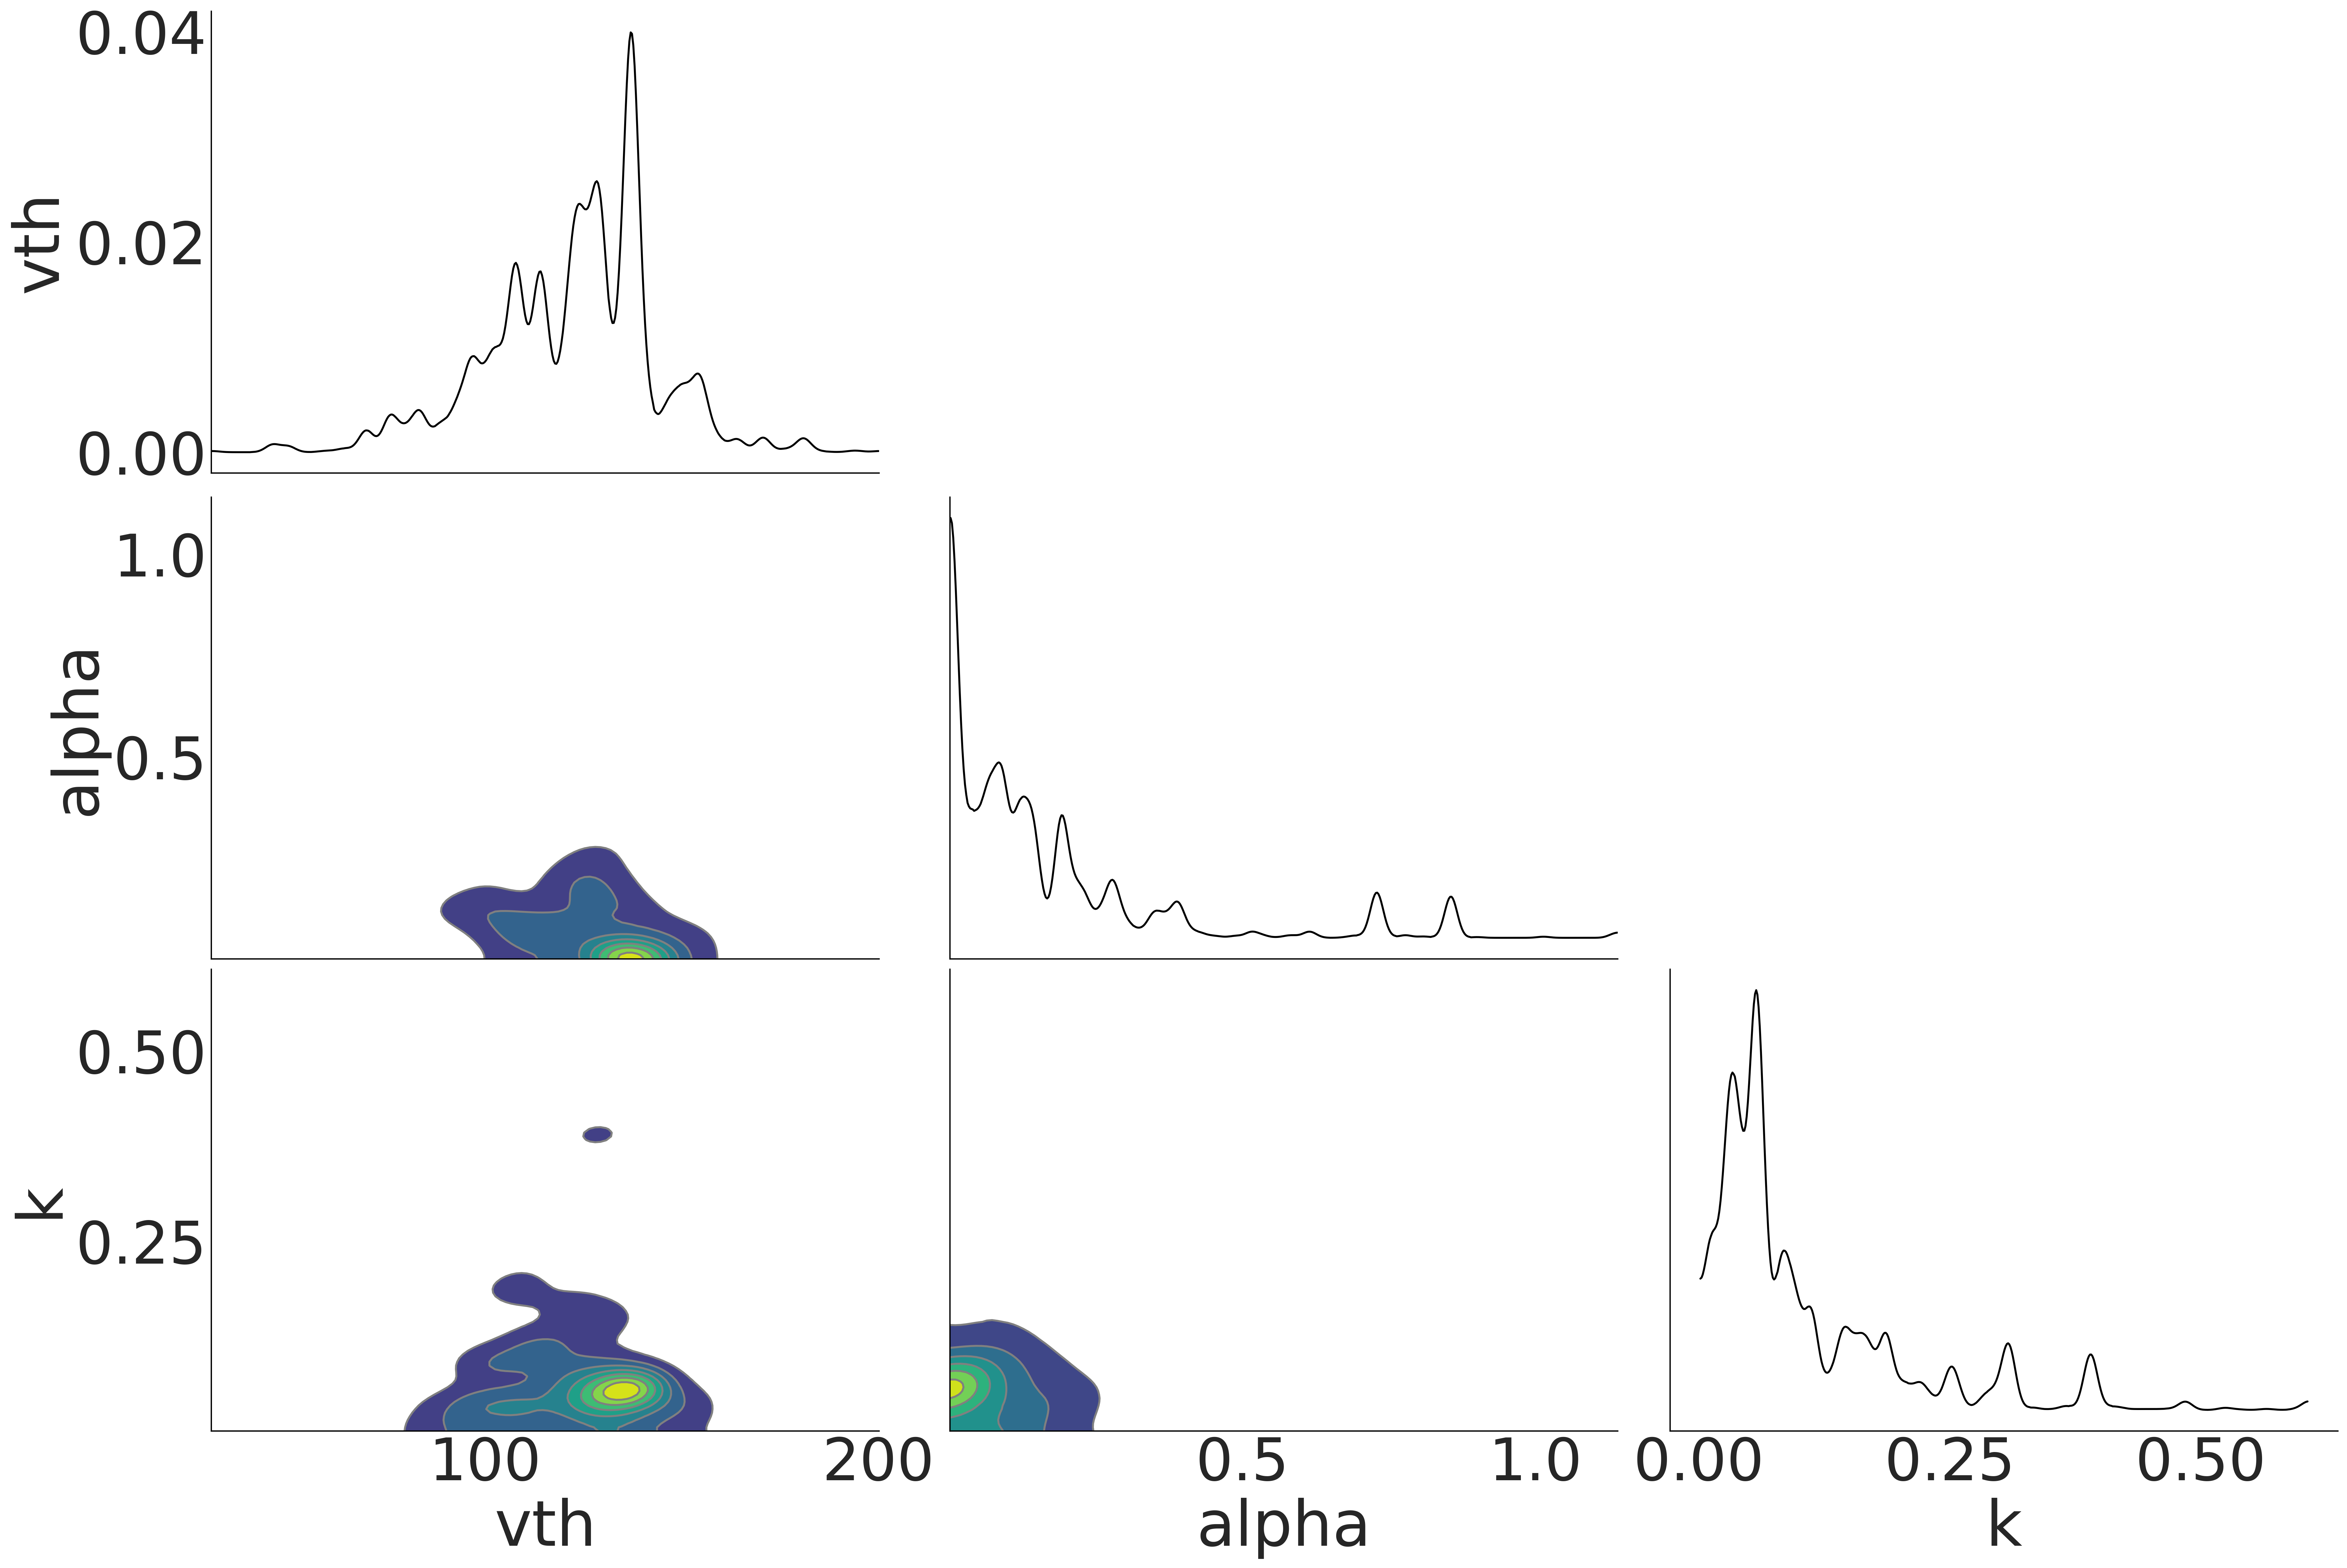

In [10]:
az.plot_pair(trace_g, 
             kind = "kde", 
            marginals = True,
            textsize = 45,
            kde_kwargs = {"contourf_kwargs":{"cmap":plt.cm.viridis}})

## Bayesian u-vaue and p-value for obsvered and posterior/prior predictive

Text(0.5, 1.0, 'ϵ=1, mse=275.68')

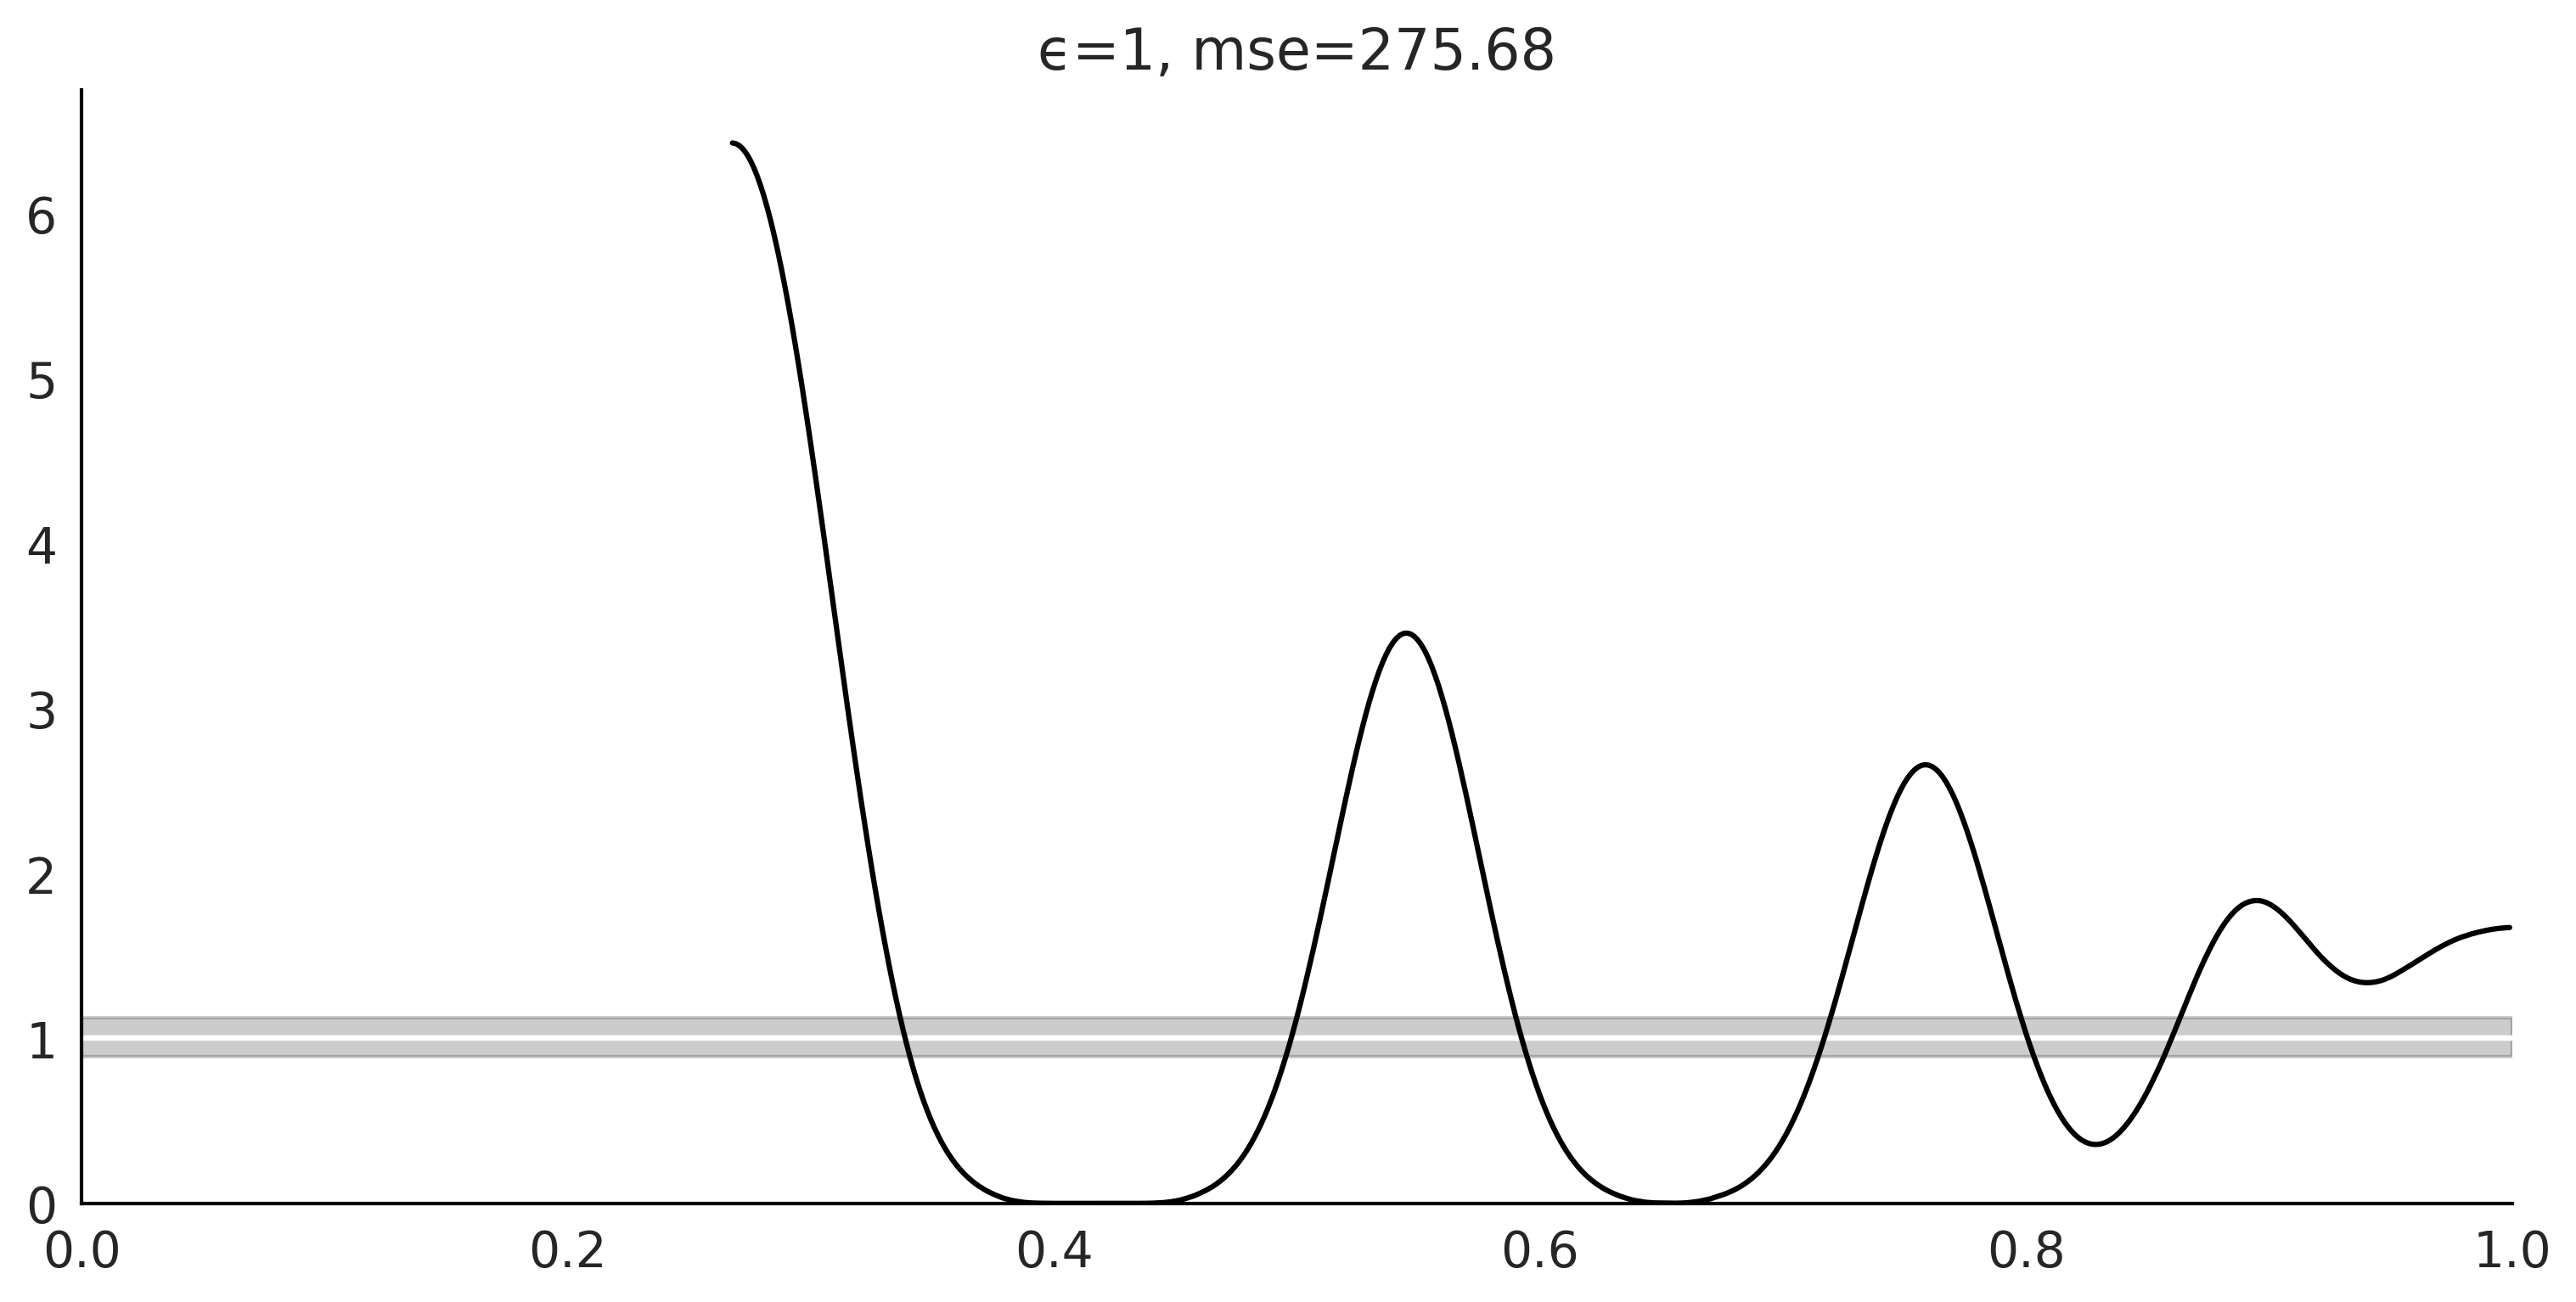

In [15]:
trace_g
pp

epsilons = 1

_, ax = plt.subplots(1, 1, figsize=(10,5))

pp_vals = np.reshape(pp.posterior_predictive["s"][:,:,1], (4000, -1))
tstat_pit = np.mean(pp_vals <= xs, axis=0)
_, tstat_pit_dens = az.kde(tstat_pit.to_numpy())

ax.axhline(1, color="w")
az.plot_bpv(pp, kind="u_value", ax=ax, reference="analytical")
ax.tick_params(axis='both', pad=7)
ax.set_title(f"ϵ={epsilons}, mse={np.mean((1 - tstat_pit_dens)**2) * 100:.2f}")

<Axes: title={'center': 's'}>

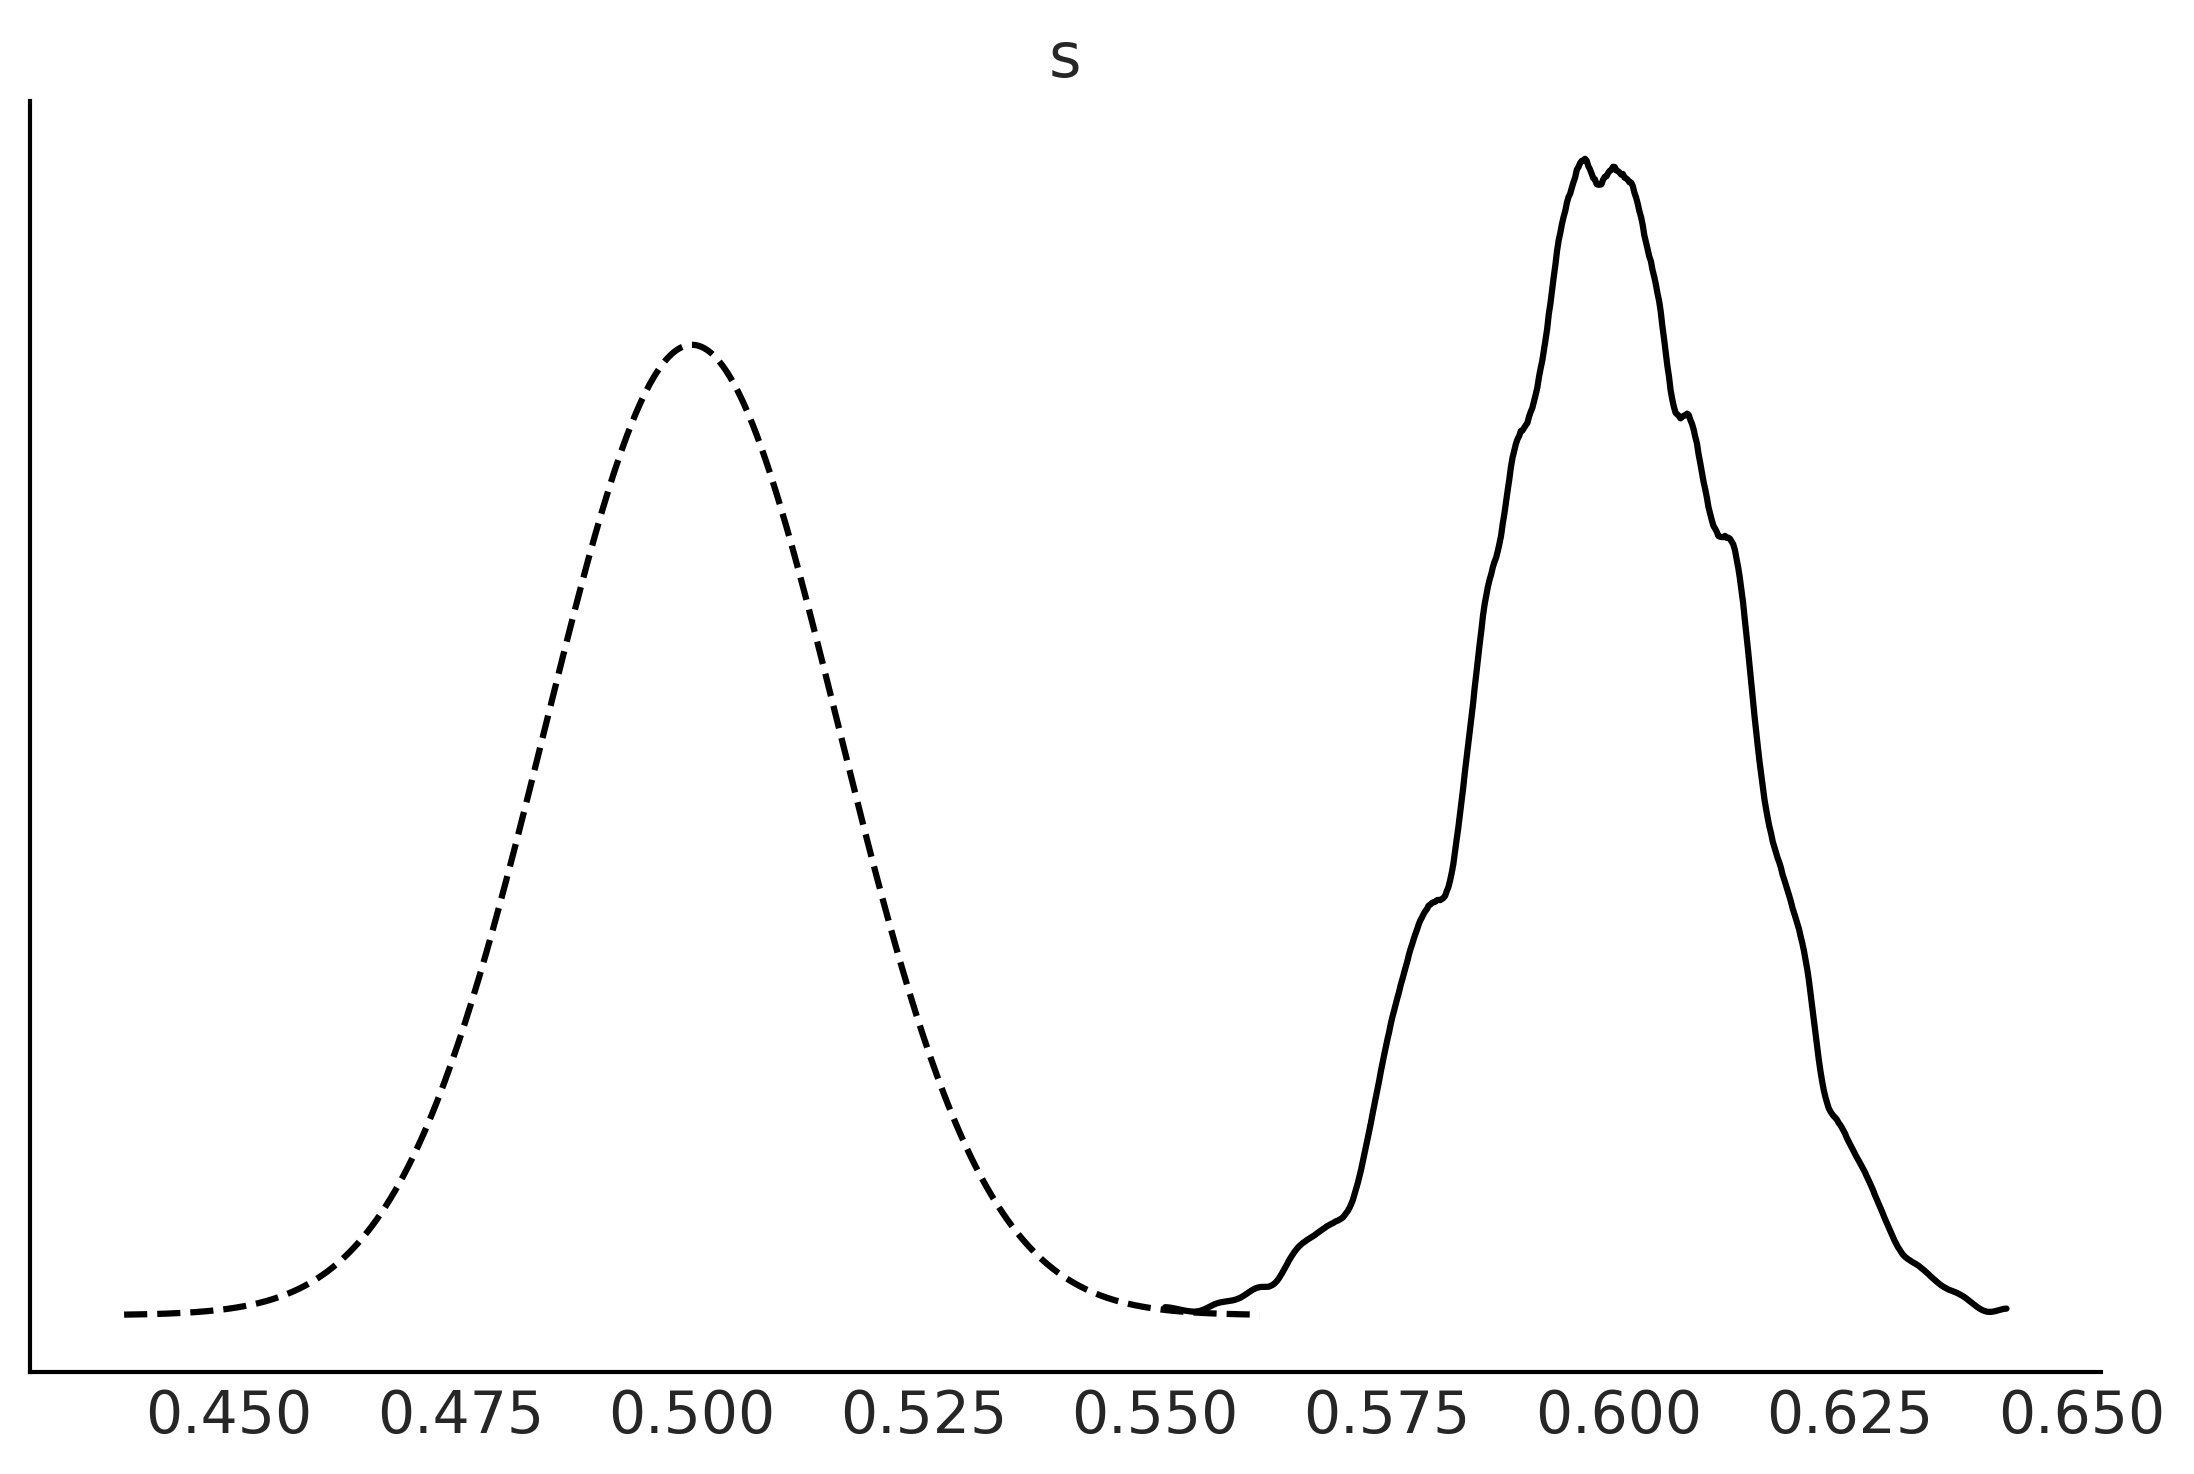

In [50]:
az.plot_bpv(pp, kind="p_value")

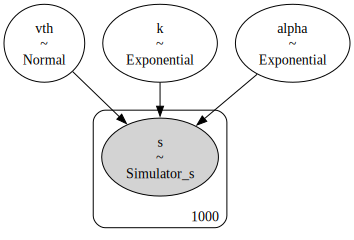

In [17]:
pm.model_to_graphviz(lf)

# Multiple fitting with different tolerance values

In [19]:
with pm.Model() as lf_001:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 0.1,
                     observed = xs)
    
    trace_g_001 = pm.sample_prior_predictive()
    
    trace_g_001.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp_001 = pm.sample_posterior_predictive(trace_g_001)
    
    
with pm.Model() as lf_01:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 1,
                     observed = xs)
    
    trace_g_01 = pm.sample_prior_predictive()
    
    trace_g_01.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp_01 = pm.sample_posterior_predictive(trace_g_01)
    
    
with pm.Model() as lf_02:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 2,
                     observed = xs)
    
    trace_g_02 = pm.sample_prior_predictive()
    
    trace_g_02.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp_02 = pm.sample_posterior_predictive(trace_g_02)
    
    
with pm.Model() as lf_05:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 5,
                     observed = xs)
    
    trace_g_05 = pm.sample_prior_predictive()
    
    trace_g_05.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp_05 = pm.sample_posterior_predictive(trace_g_05)
    
with pm.Model() as lf_10:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 10,
                     observed = xs)
    
    trace_g_10 = pm.sample_prior_predictive()
    
    trace_g_10.extend(pm.sample_smc(1000, kernel="ABC",
                            parallel=True))
    
    pp_10 = pm.sample_posterior_predictive(trace_g_10)
    
with pm.Model() as lf_NUTS:
    alpha = pm.Exponential('alpha', scale = 0.2)
    k = pm.Exponential('k', scale = 0.1)
    vth = pm.Normal('vth', mu = 120, sigma = 25)
    s = pm.Simulator('s', model, params = [alpha, k, vth],
                     distance = "gaussian",
                     sum_stat = "sort",          
                     epsilon = 0.1,
                     observed = xs)
    
    trace_g_nuts = pm.sample()
    

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [s]


Output()

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [s]


Output()

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

Sampling: [alpha, k, s, vth]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [k]
>Slice: [vth]


Output()

ParallelSamplingError: Chain 0 failed with: lam value too large
Apply node that caused the error: Simulator_s_rv{"(),(),()->()"}(simulator_rng, [1000], ExpandDims{axis=0}.0, ExpandDims{axis=0}.0, ExpandDims{axis=0}.0)
Toposort index: 6
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,))]
Inputs shapes: ['No shapes', (1,), (1,), (1,), (1,)]
Inputs strides: ['No strides', (8,), (8,), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x1A46F547140, array([1000], dtype=int64), array([7.05683158]), array([1.15069375e+17]), array([119.99390275])]
Outputs clients: [[output[1](Simulator_s_rv{"(),(),()->()"}.0)], [SortOp{kind='quicksort'}(Simulator_s_rv{"(),(),()->()"}.out, -1)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_16532\3346788896.py", line 99, in <module>
    trace_g_nuts = pm.sample()
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\sampling\mcmc.py", line 716, in sample
    step = assign_step_methods(model, step, methods=pm.STEP_METHODS, step_kwargs=kwargs)
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\sampling\mcmc.py", line 237, in assign_step_methods
    return instantiate_steppers(model, steps, selected_steps, step_kwargs)
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\sampling\mcmc.py", line 138, in instantiate_steppers
    step = step_class(vars=vars, model=model, **args)
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\step_methods\compound.py", line 152, in __new__
    step.__init__([var], *args, **kwargs)
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\step_methods\slicer.py", line 75, in __init__
    [logp], raveled_inp = join_nonshared_inputs(
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\pytensorf.py", line 612, in join_nonshared_inputs
    new_outputs = [
  File "C:\Users\User\anaconda33\Lib\site-packages\pymc\pytensorf.py", line 613, in <listcomp>
    pytensor.clone_replace(output, replace, rebuild_strict=False) for output in outputs

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

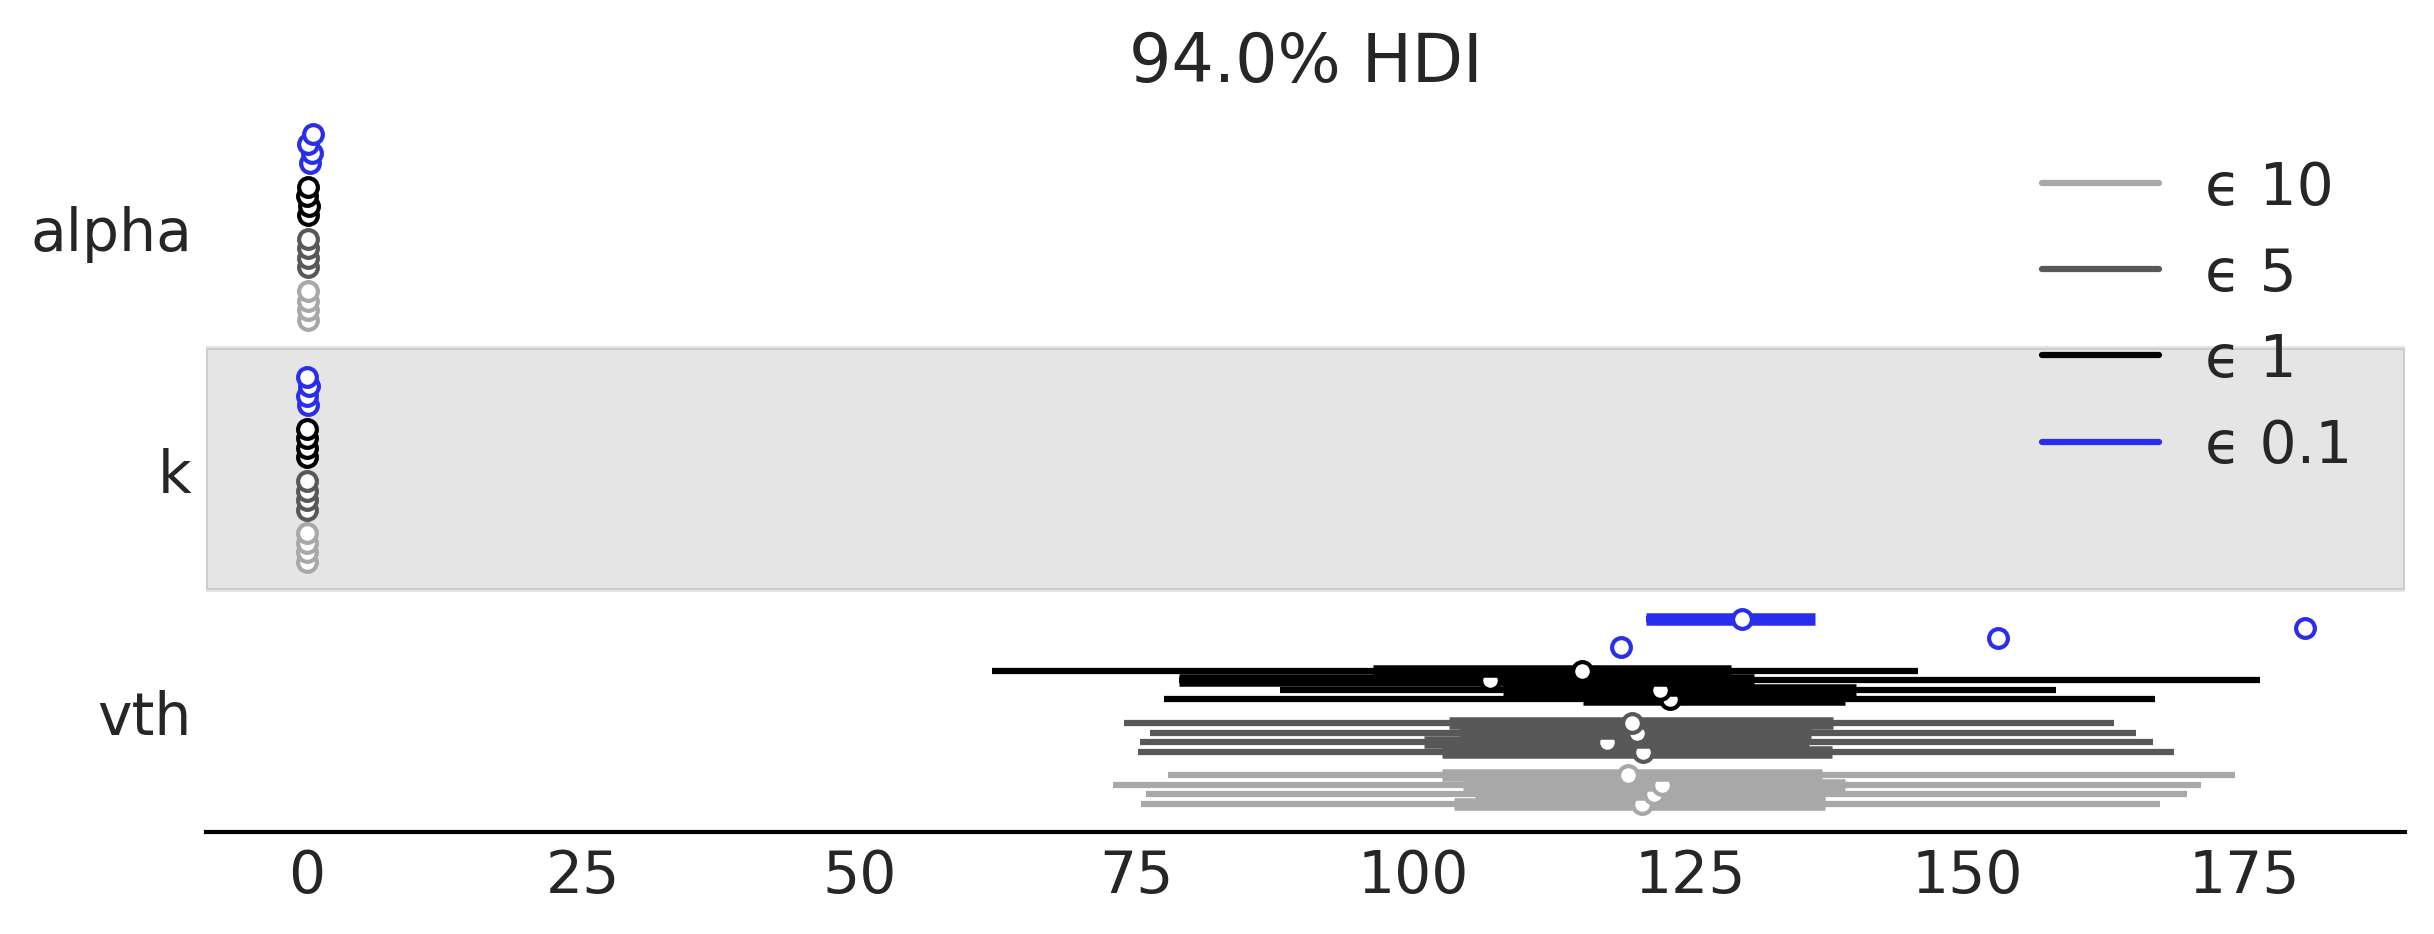

In [23]:
traces = [trace_g_001, trace_g_01, trace_g_05, trace_g_10]
az.plot_forest(traces, model_names = ["ϵ 0.1", "ϵ 1", "ϵ 5", "ϵ 10"],
               colors = ["#2a2eec", "#000000", "#585858", "#A8A8A8"],
               figsize = (8, 3));
#plt.savefig("img/chp08/trace_g_many_eps.png")

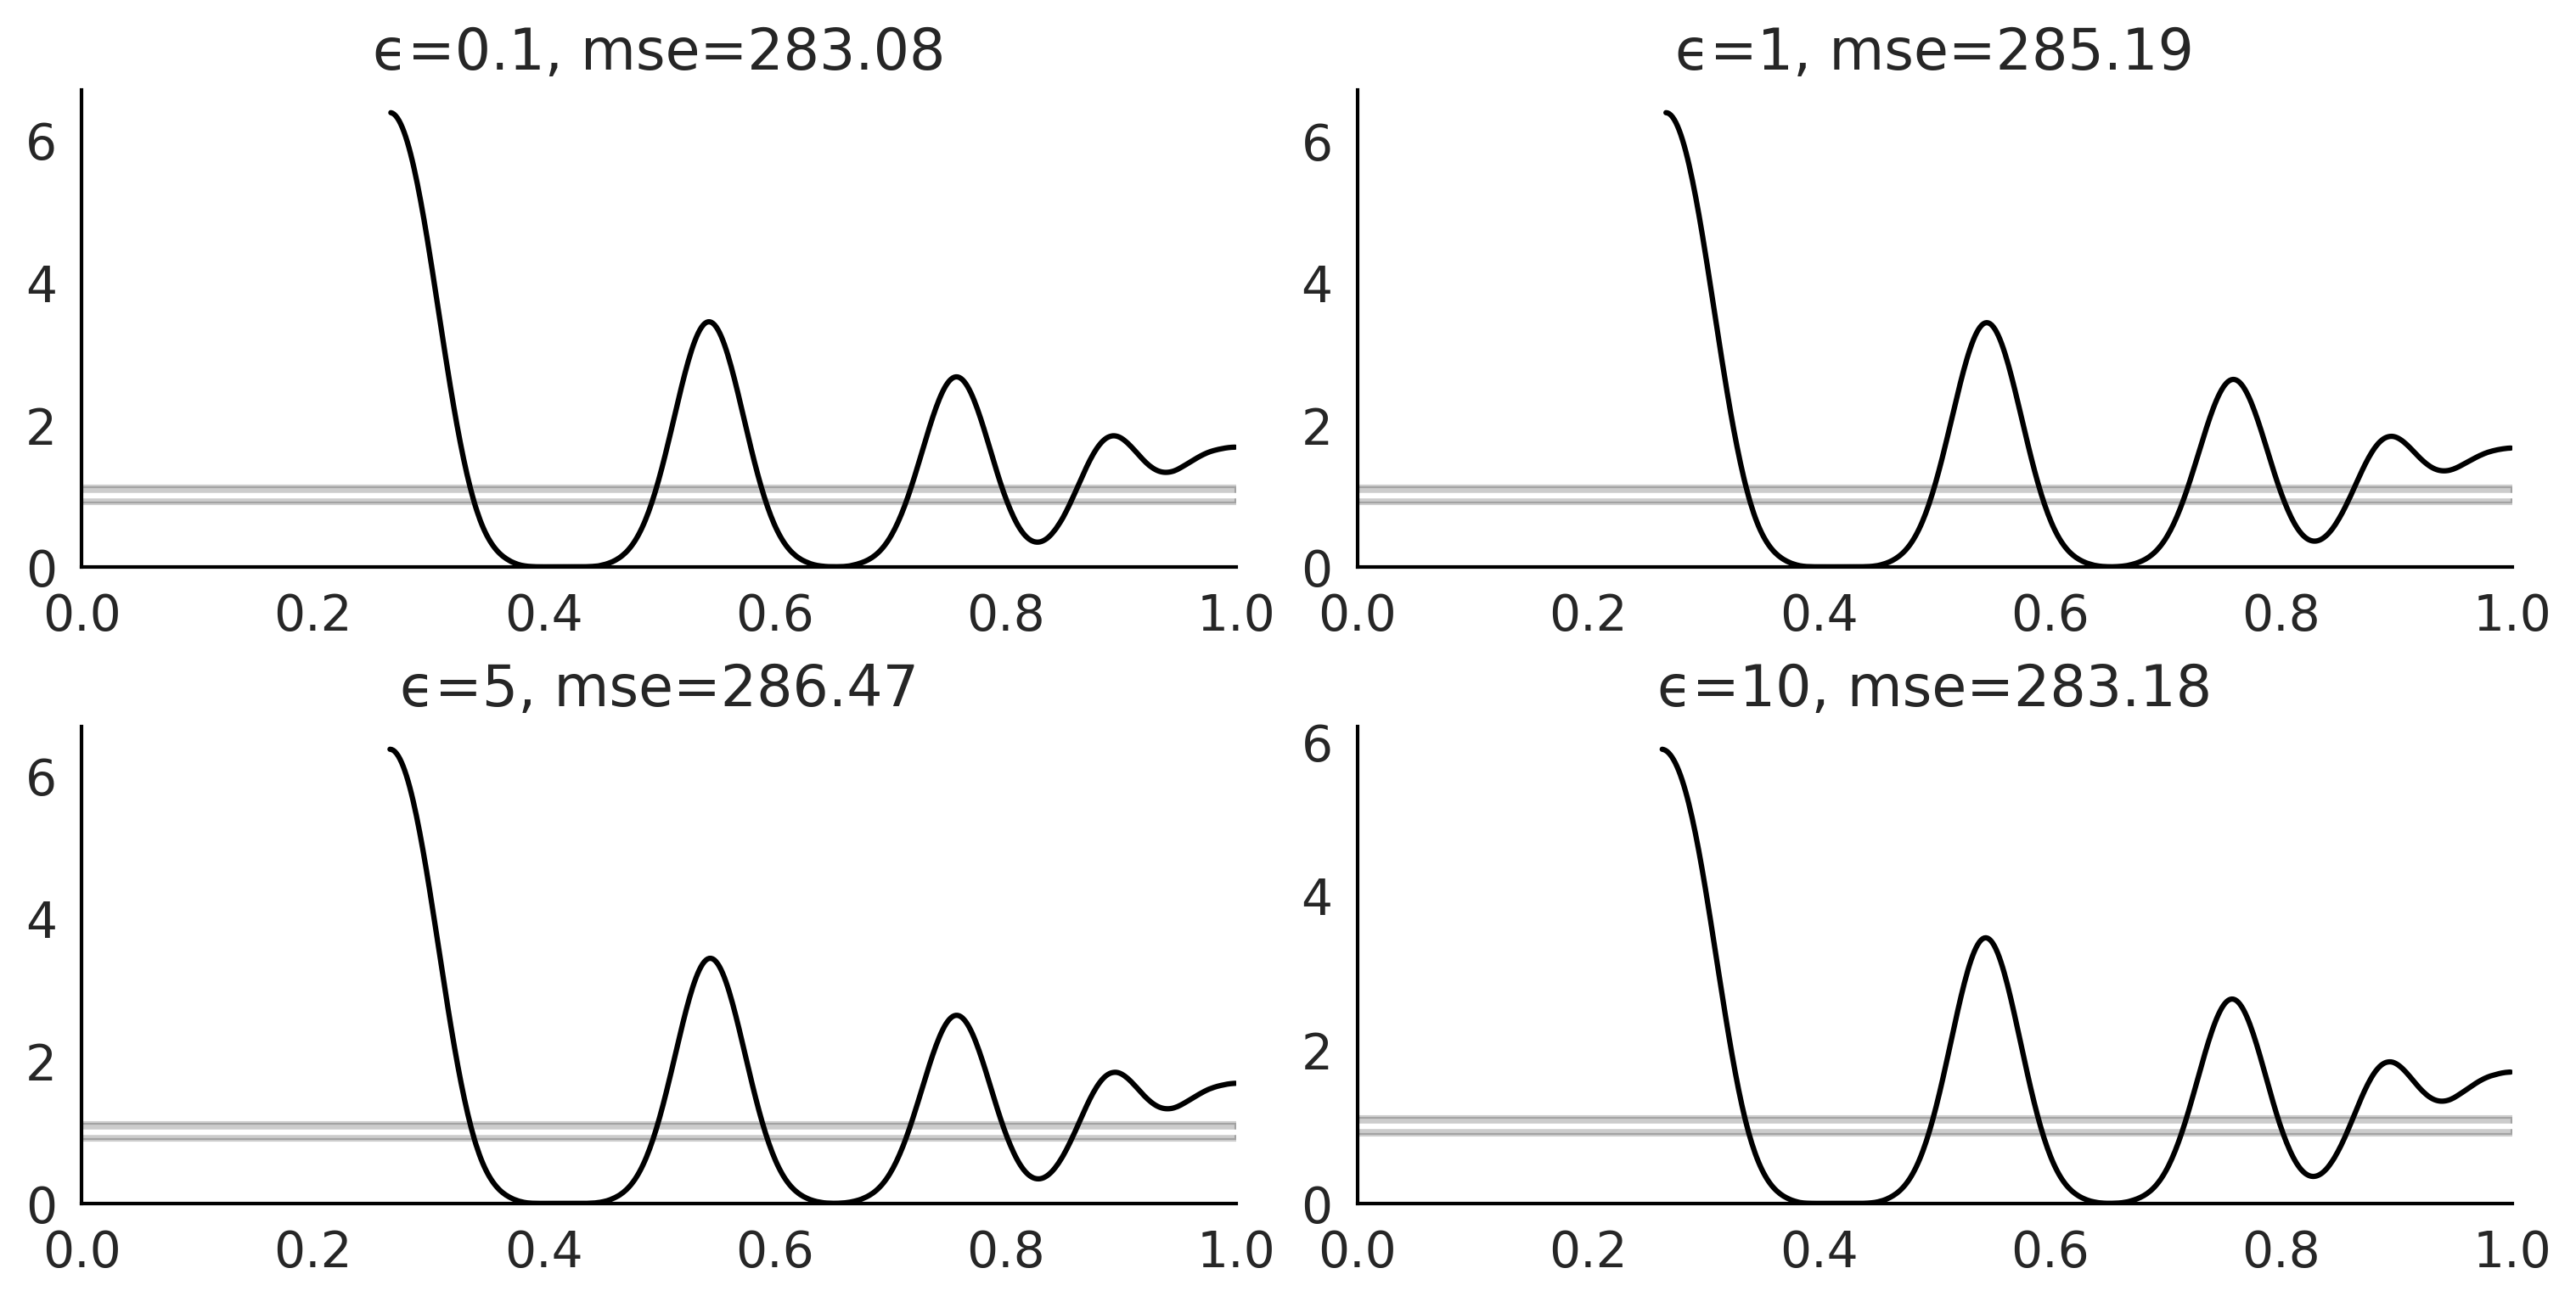

In [25]:
traces_ = [trace_g_001, trace_g_01, trace_g_05, trace_g_10]
sim_data_ = [pp_001, pp_01, pp_05, pp_10]
epsilons = [0.1, 1, 5, 10]

_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):

    pp_vals = np.reshape(sim_data_[i].posterior_predictive["s"][:,:,1], (4000, -1))
    tstat_pit = np.mean(pp_vals <= xs, axis=0)
    _, tstat_pit_dens = az.kde(tstat_pit.to_numpy())
    
    ax.axhline(1, color="w")
    az.plot_bpv(sim_data_[i], kind="u_value", ax = ax, reference="analytical")
    ax.tick_params(axis='both', pad=7)
    ax.set_title(f"ϵ={epsilons[i]}, mse={np.mean((1 - tstat_pit_dens)**2) * 100:.2f}")

plt.savefig("bpv_g_many_eps_00.png")


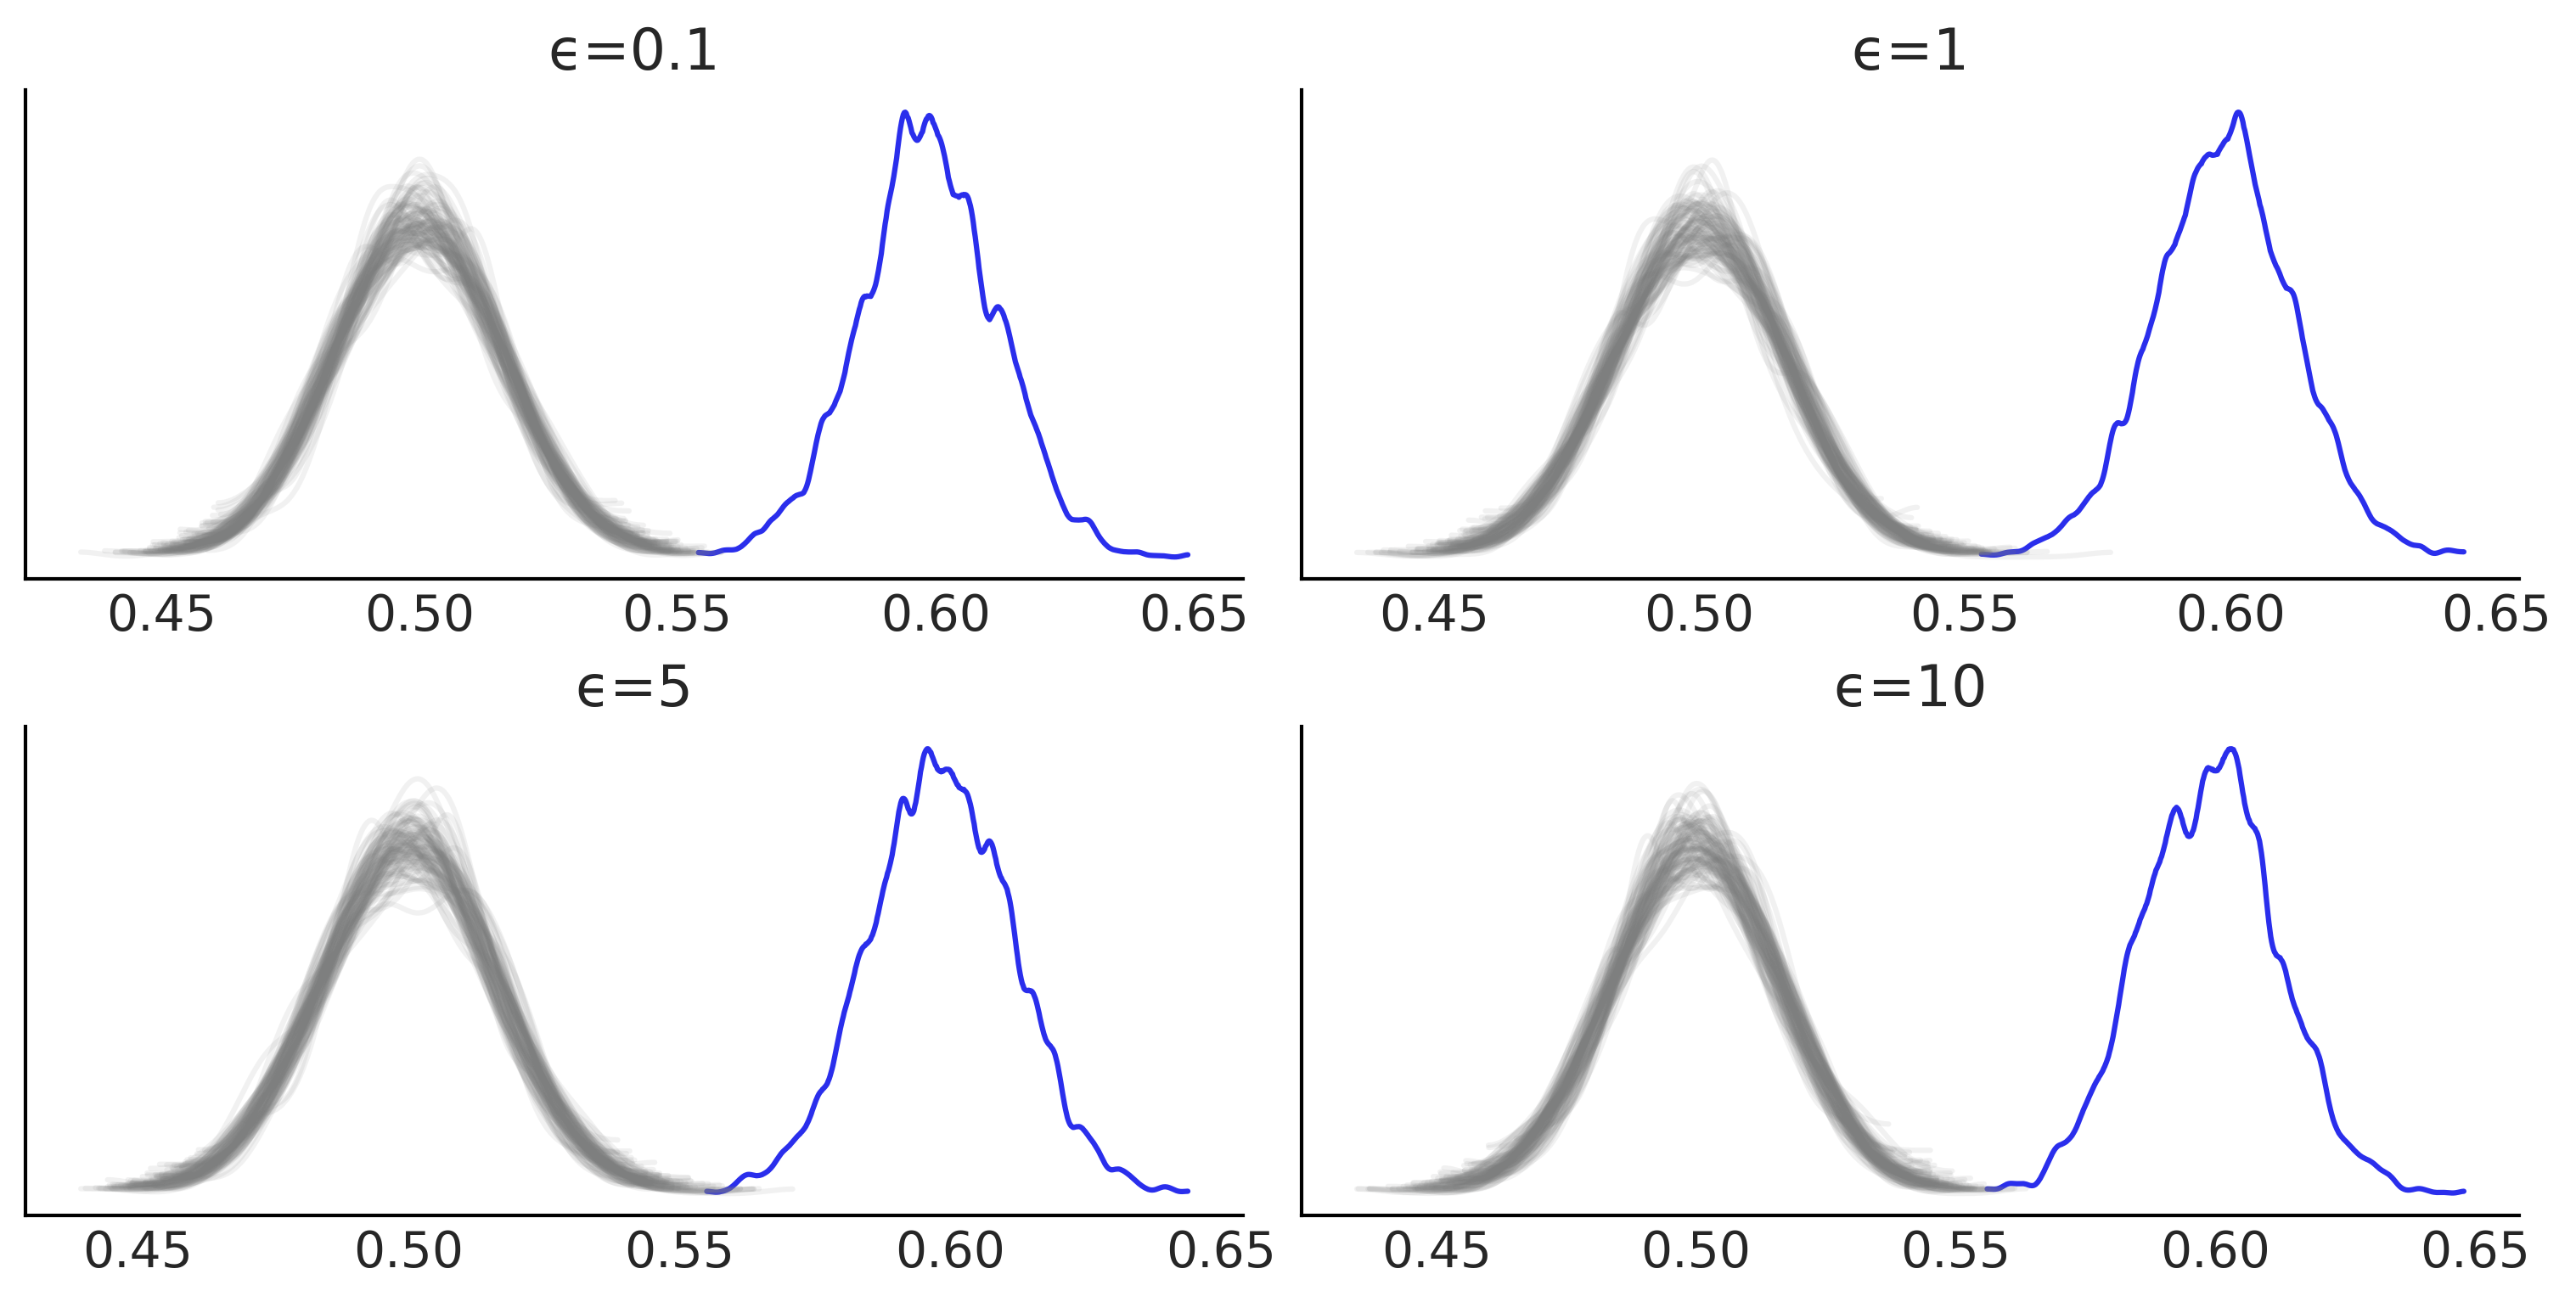

In [27]:
_, ax = plt.subplots(2, 2, figsize=(10,5))

ax = ax.ravel()
for i in range(4):

    az.plot_bpv(sim_data_[i], kind="p_value", reference='samples', color="C4", ax=ax[i],
               plot_ref_kwargs={"color":"C2"})
    ax[i].set_title(f"ϵ={epsilons[i]}")
plt.savefig("bpv_g_many_eps_01.png")

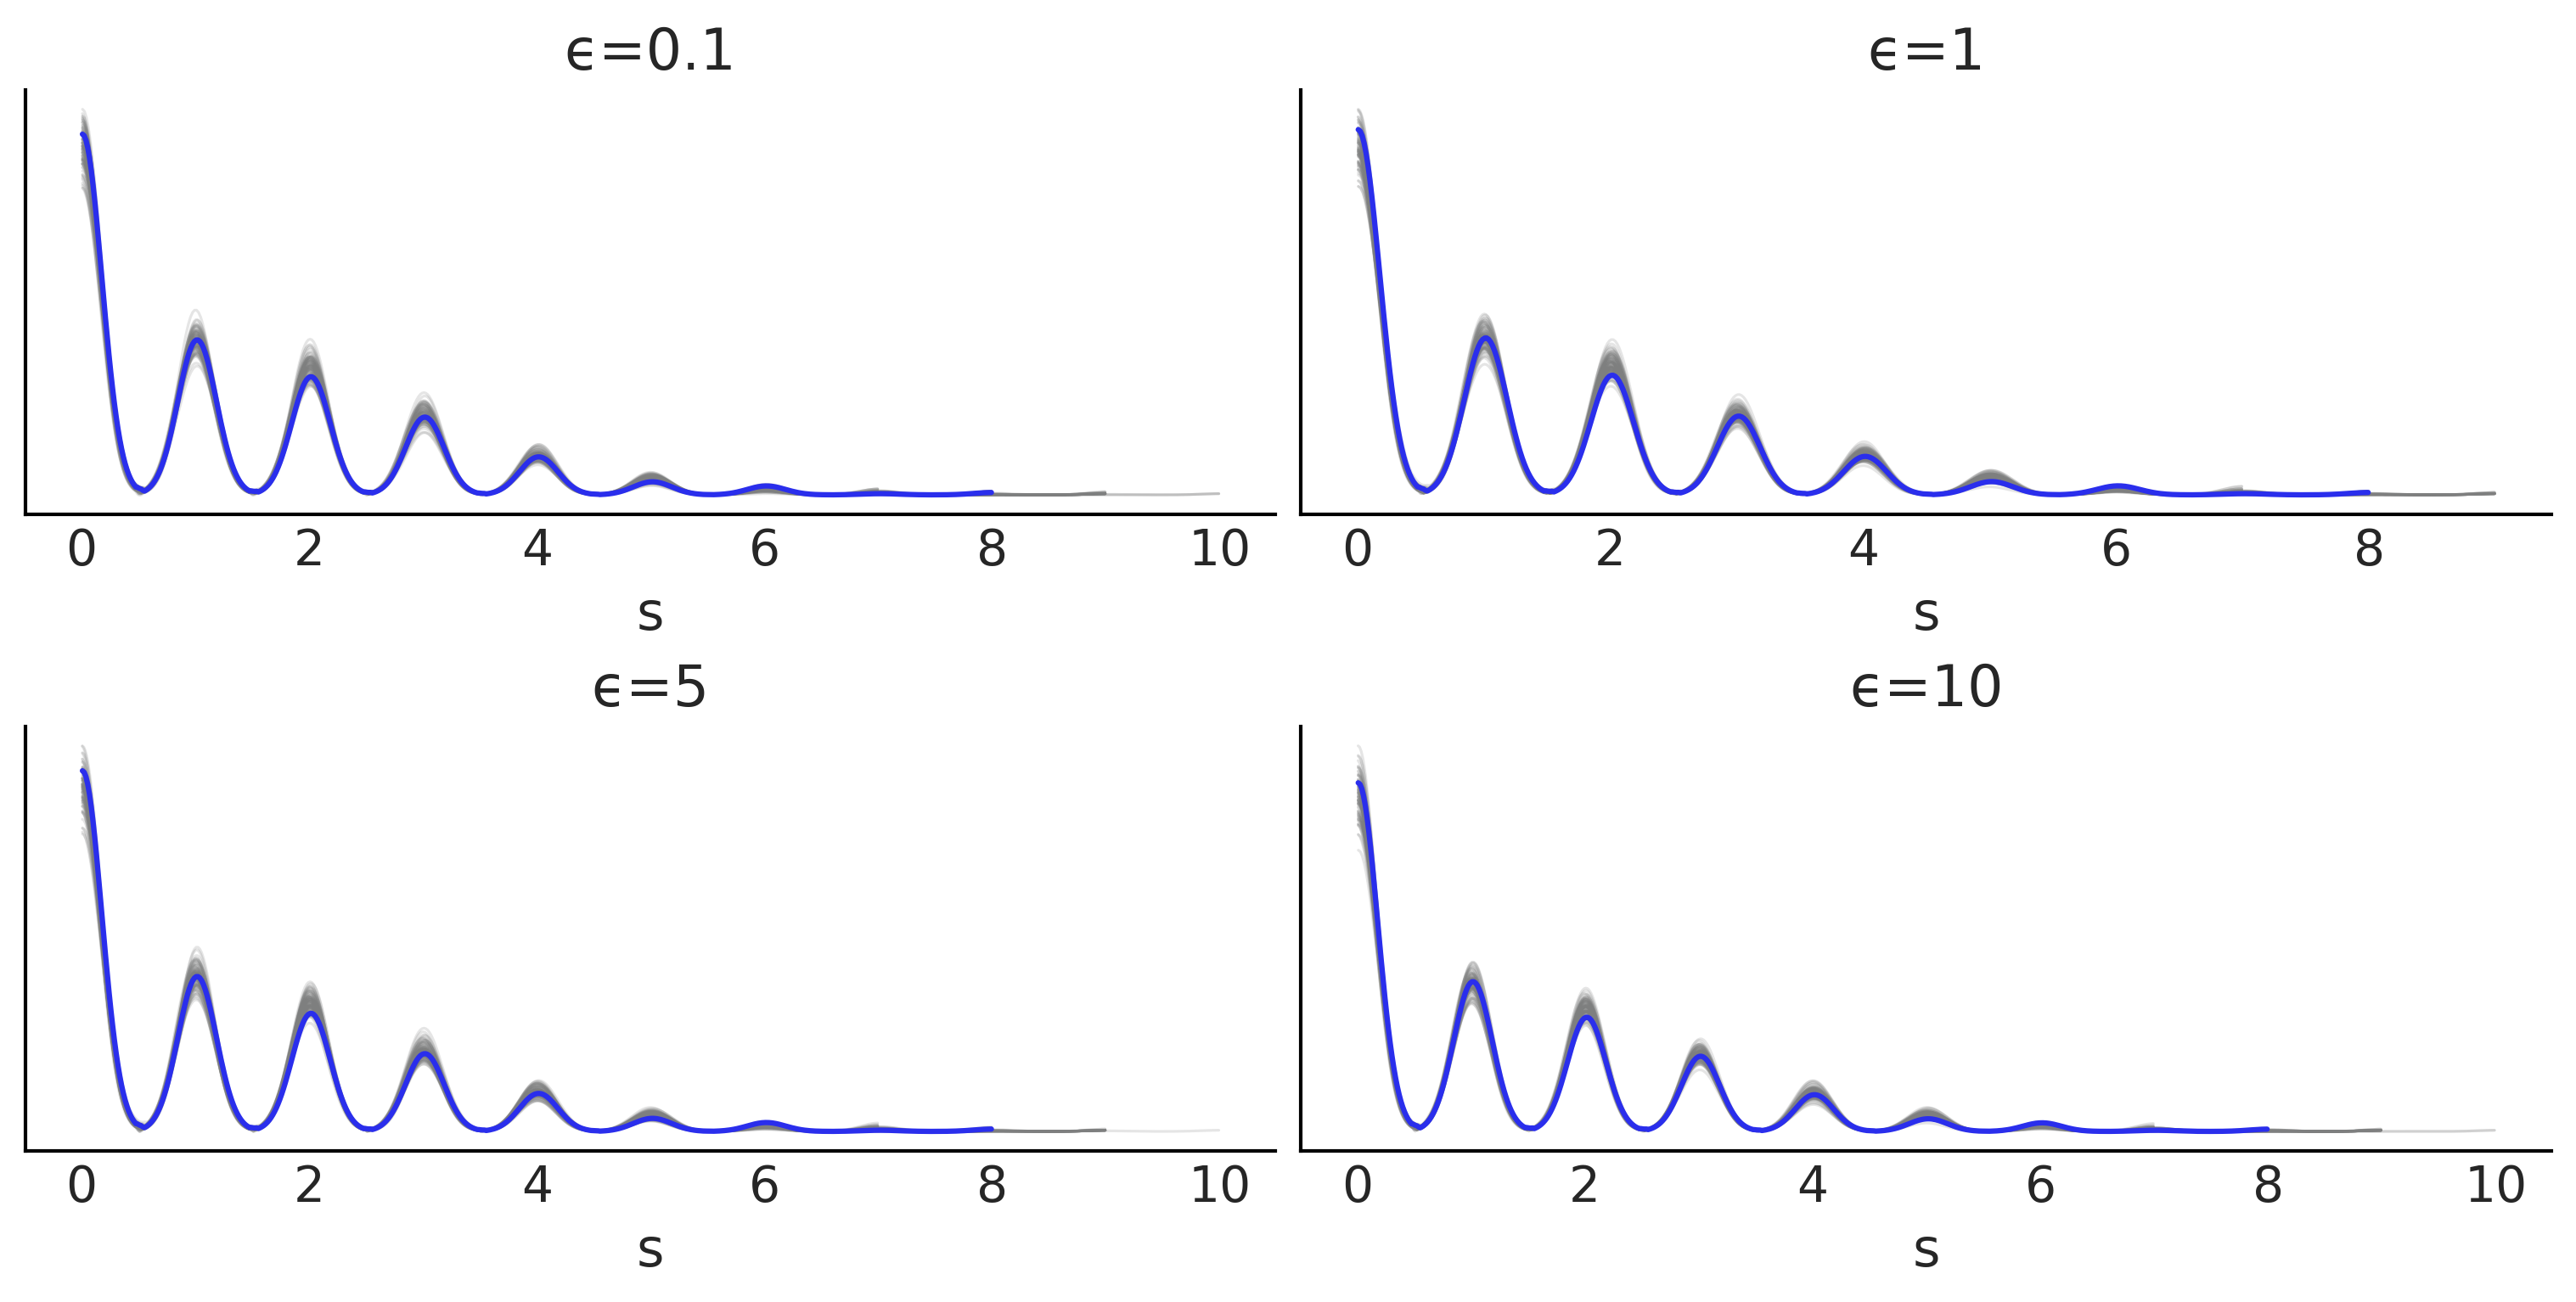

In [29]:
_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    
    az.plot_ppc(sim_data_[i], num_pp_samples=100, ax=ax, color="C2",
                mean=False, legend=False, observed=False)
    az.plot_kde(traces_[i].observed_data['s'].to_numpy(), plot_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("s")
    ax.set_title(f"ϵ={epsilons[i]}")
plt.savefig("ppc_g_many_eps.png")

In [31]:
az.compare(
    {'m1':trace_g_001,'m2':trace_g_01},
    scale='deviance',
    ic='waic',
    method="BB-pseudo-BMA"
)

TypeError: Encountered error in ELPD computation of compare.